L’objectif de cette section est d’évaluer la capacité d’un modèle de Machine Learning à extraire une propriété physique simple d’un état quantique à partir de mesures bruitées. Dans le cadre de la tomographie quantique, on souhaite en général reconstruire l’état réel du qubit, représenté par son vecteur de Bloch (X_real, Y_real, Z_real). Cependant, avant d’aborder cette tâche plus complexe de régression, il est utile de commencer par un problème plus simple : déterminer si l’état appartient à l’hémisphère nord ou à l’hémisphère sud de la sphère de Bloch.

Pour cela, on définit une étiquette binaire directement à partir de l’état réel simulé : label = 1 si Z_real ≥ 0, et 0 sinon. Cette propriété géométrique simple découle uniquement de l’état réel, c’est-à-dire l’état effectivement mesuré après bruit statistique et éventuellement bruit de canal. L’objectif de la classification est donc de prédire cette étiquette en utilisant uniquement les mesures brutes bruitées, à savoir les valeurs X_mean, Y_mean et Z_mean obtenues à partir d’un nombre limité de shots.

Ce test sert de validation préalable essentielle. S’il est impossible pour un modèle de classification de récupérer une propriété globale aussi simple que le signe de Z_real, il est illusoire d’espérer réussir une reconstruction complète du vecteur de Bloch réel via une régression plus fine. À l’inverse, si la classification réussit malgré le bruit statistique, cela montre que les features contiennent bien une partie exploitable de l’information physique.

En résumé, cette classification n’a pas pour but de résoudre la tomographie complète, mais de tester de manière contrôlée et progressive la capacité d’un modèle à extraire une information physique réelle à partir de mesures bruitées. Ce type d’analyse constitue une étape préparatoire logique avant de s’engager dans des tâches de reconstruction plus précises de l’état quantique.

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from dataset_build.clf_dtSet_hugo import build_purity_classification_dataset

We can use the Strong law of numbers to prepare the n_shots value. Using graphical plots to see the convergence of the random average variable.

In [4]:
# Dataset creation

df_purity, X, y = build_purity_classification_dataset(
    n_shots=100,
    n_states_total=5000,
    mixed_proportion=0.3  # proportion of mixed states
)

print(f"Dataset shape: {df_purity.shape}")
print(f"Labels distribution:\n{y.value_counts()}")
print(f"\nDataset columns:\n{df_purity.columns.tolist()}")
print(f"\X columns (à revoir):\n{X.columns.tolist()}")

Dataset shape: (5000, 14)
Labels distribution:
label_purity
1    3500
0    1500
Name: count, dtype: int64

Dataset columns:
['X_mean', 'Y_mean', 'Z_mean', 'X_real', 'Y_real', 'Z_real', 'theta_ideal', 'phi_ideal', 'X_ideal', 'Y_ideal', 'Z_ideal', 'bloch_radius_real', 'is_pure', 'label_purity']
\X columns (à revoir):
['X_mean', 'Y_mean', 'Z_mean', 'bloch_radius_real']


In [5]:
df_purity.head(10)

,X_mean,Y_mean,Z_mean,X_real,Y_real,Z_real,theta_ideal,phi_ideal,X_ideal,Y_ideal,Z_ideal,bloch_radius_real,is_pure,label_purity
0,-0.34,-0.06,-0.92,-0.379516,-0.069939,-0.922538,2.745403,3.323834,-0.379516,-0.069939,-0.922538,1.000000,True,1
1,-0.86,0.02,0.56,-0.880593,-0.039491,0.472225,1.078983,3.186408,-0.880593,-0.039491,0.472225,1.000000,True,1
2,-0.76,-0.12,0.58,-0.770391,-0.180044,0.611622,0.912687,3.371177,-0.770391,-0.180044,0.611622,1.000000,True,1
3,0.12,-0.48,0.44,0.088862,-0.478898,0.511669,0.879782,4.960608,0.189319,-0.746982,0.637319,0.706431,False,0
4,0.08,-0.72,-0.62,0.133797,-0.714615,-0.686603,2.327603,4.897476,0.133797,-0.714615,-0.686603,1.000000,True,1
5,0.12,-0.32,-0.94,0.117780,-0.317888,-0.940784,2.795733,5.067215,0.117780,-0.317888,-0.940784,1.000000,True,1
6,0.50,0.82,-0.10,0.536625,0.835894,-0.115386,1.686440,1.000082,0.536625,0.835894,-0.115386,1.000000,True,1
7,-0.78,0.64,0.18,-0.731191,0.638787,0.239398,1.329051,2.423541,-0.731191,0.638787,0.239398,1.000000,True,1
8,-0.06,0.02,0.40,-0.090605,0.082563,0.553859,0.296657,2.674101,-0.260959,0.131736,0.956319,0.567262,False,0
9,0.16,-0.94,0.52,-0.019028,-0.863398,0.504164,1.042382,4.690354,-0.019028,-0.863398,0.504164,1.000000,True,1


In [6]:
df_purity.describe()

,X_mean,Y_mean,Z_mean,X_real,Y_real,Z_real,theta_ideal,phi_ideal,X_ideal,Y_ideal,Z_ideal,bloch_radius_real,label_purity
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-0.000036,0.000864,0.012352,-0.000671,0.001427,0.009656,1.561348,3.115729,-0.000809,0.001772,0.009393,0.898379,0.700000
std,0.532056,0.538324,0.539335,0.525269,0.531478,0.532562,0.687595,1.808916,0.571272,0.581493,0.579330,0.186678,0.458303
min,-1.000000,-1.000000,-1.000000,-0.999857,-0.999285,-0.999614,0.052663,0.002319,-0.999857,-0.999285,-0.999614,0.230542,0.000000
25%,-0.420000,-0.420000,-0.400000,-0.401234,-0.423250,-0.414325,1.044688,1.539140,-0.488923,-0.503035,-0.497713,0.879582,0.000000
50%,0.000000,0.000000,0.020000,-0.001882,0.008334,0.022376,1.541763,3.110967,-0.002185,0.008346,0.029030,1.000000,1.000000
75%,0.420000,0.420000,0.440000,0.413865,0.412786,0.424435,2.091756,4.680451,0.490631,0.500625,0.502172,1.000000,1.000000
max,1.000000,1.000000,1.000000,0.999956,0.998989,0.998614,3.113796,6.282833,0.999956,0.999220,0.998614,1.000000,1.000000


array([[<Axes: title={'center': 'X_mean'}>,
        <Axes: title={'center': 'Y_mean'}>,
        <Axes: title={'center': 'Z_mean'}>,
        <Axes: title={'center': 'X_real'}>],
       [<Axes: title={'center': 'Y_real'}>,
        <Axes: title={'center': 'Z_real'}>,
        <Axes: title={'center': 'theta_ideal'}>,
        <Axes: title={'center': 'phi_ideal'}>],
       [<Axes: title={'center': 'X_ideal'}>,
        <Axes: title={'center': 'Y_ideal'}>,
        <Axes: title={'center': 'Z_ideal'}>,
        <Axes: title={'center': 'bloch_radius_real'}>],
       [<Axes: title={'center': 'label_purity'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

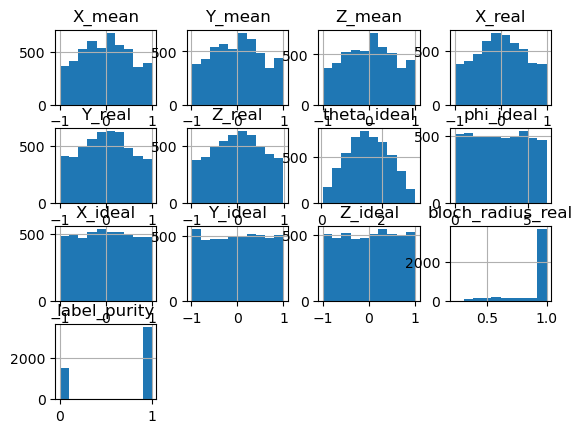

In [7]:
df_purity.hist()

The X,Y and Z are following a unimodal Gaussian distribution, so that the dataset creation is normal.

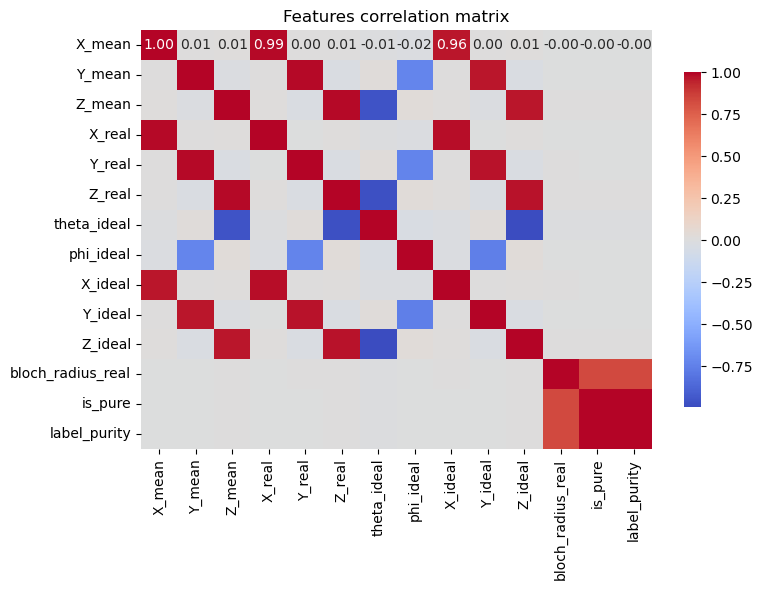

In [8]:
# correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_purity.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Features correlation matrix')
plt.tight_layout()
plt.show()

Putting bloch_radius_real creates an overfitting training

In [9]:
X_purity=df_purity[['X_mean','Y_mean','Z_mean']]
X_purity.head()

,X_mean,Y_mean,Z_mean
0,-0.34,-0.06,-0.92
1,-0.86,0.02,0.56
2,-0.76,-0.12,0.58
3,0.12,-0.48,0.44
4,0.08,-0.72,-0.62


In [10]:
y=df_purity['label_purity']

Transforming data for training models

In [11]:
scaler=StandardScaler()
X_purity_scaled=scaler.fit_transform(X_purity)

X_train, X_test, y_train, y_test = train_test_split(
    X_purity_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")

Training set size: 4000 samples


Training SVC models

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svc = SVC()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # utiliser tous les processeurs disponibles
)

# Entraîner le modèle avec recherche en grille
print("Démarrage de GridSearchCV...")
grid_search.fit(X_train, y_train)

print(f"\nMeilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score CV : {grid_search.best_score_:.4f}")

Démarrage de GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Meilleurs paramètres : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Meilleur score CV : 0.9213

Meilleurs paramètres : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Meilleur score CV : 0.9213


In [13]:

# Evaluating on the test set
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracité sur l'ensemble de test : {test_accuracy:.4f}")
print(classification_report(y_test, y_pred))


Accuracité sur l'ensemble de test : 0.9370
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       300
           1       0.92      0.99      0.96       700

    accuracy                           0.94      1000
   macro avg       0.95      0.90      0.92      1000
weighted avg       0.94      0.94      0.94      1000



without parameter

In [14]:
model_SVC=SVC(random_state=42)
model_SVC.fit(X_train, y_train)
y_pred_SVC=model_SVC.predict(X_test)

print(classification_report(y_test, y_pred_SVC))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87       300
           1       0.91      1.00      0.95       700

    accuracy                           0.93      1000
   macro avg       0.95      0.89      0.91      1000
weighted avg       0.94      0.93      0.93      1000



Analyse de l'impact de n_shots sur les performances...

n_shots=  10 | Accuracy: 0.8040 ± 0.0060
n_shots=  10 | Accuracy: 0.8040 ± 0.0060
n_shots=  50 | Accuracy: 0.8960 ± 0.0144
n_shots=  50 | Accuracy: 0.8960 ± 0.0144
n_shots= 100 | Accuracy: 0.9225 ± 0.0072
n_shots= 100 | Accuracy: 0.9225 ± 0.0072
n_shots= 500 | Accuracy: 0.9680 ± 0.0043
n_shots= 500 | Accuracy: 0.9680 ± 0.0043
n_shots=1000 | Accuracy: 0.9625 ± 0.0052
n_shots=1000 | Accuracy: 0.9625 ± 0.0052


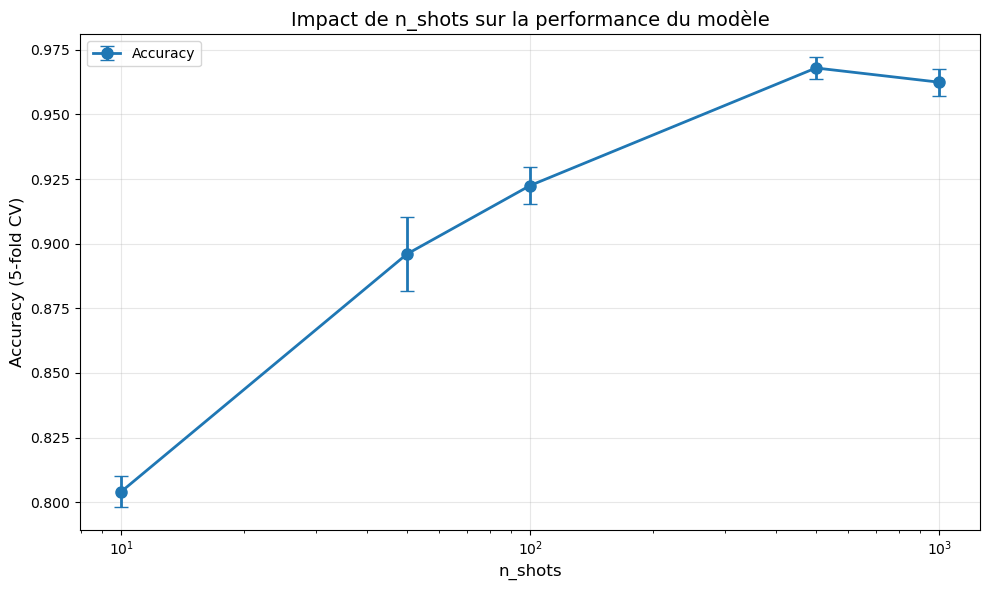


✓ n_shots optimal : 500 avec accuracy = 0.9680


In [15]:
# Analyser l'impact de n_shots sur la performance du modèle
from sklearn.model_selection import cross_val_score

n_shots_values = [10, 50, 100, 500, 1000]
results = []

print("Analyse de l'impact de n_shots sur les performances...\n")

for n_shots in n_shots_values:
    # Générer dataset avec ce n_shots
    df_temp, X_temp, y_temp = build_purity_classification_dataset(
        n_shots=n_shots,
        n_states_total=2000,
        mixed_proportion=0.3
    )
    
    # Préparer les données
    X_temp_data = df_temp[['X_mean', 'Y_mean', 'Z_mean']]
    X_temp_scaled = StandardScaler().fit_transform(X_temp_data)
    
    # Évaluer avec le modèle optimal trouvé
    model = SVC(**grid_search.best_params_)
    cv_scores = cross_val_score(model, X_temp_scaled, y_temp, cv=5, scoring='accuracy')
    
    results.append({
        'n_shots': n_shots,
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std()
    })
    
    print(f"n_shots={n_shots:4d} | Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Visualiser la convergence
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.errorbar(results_df['n_shots'], results_df['mean_accuracy'], 
             yerr=results_df['std_accuracy'], 
             fmt='o-', capsize=5, linewidth=2, markersize=8, label='Accuracy')
plt.xlabel('n_shots', fontsize=12)
plt.ylabel('Accuracy (5-fold CV)', fontsize=12)
plt.title('Impact de n_shots sur la performance du modèle', fontsize=14)
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Recommandation
optimal_idx = results_df['mean_accuracy'].idxmax()
optimal_n_shots = results_df.loc[optimal_idx, 'n_shots']
optimal_accuracy = results_df.loc[optimal_idx, 'mean_accuracy']

print(f"\n✓ n_shots optimal : {int(optimal_n_shots)} avec accuracy = {optimal_accuracy:.4f}")

Convergence des (X_mean, Y_mean, Z_mean) selon le nombre de shots en 3D et 2D (avec loi des grands nombres)

Génération des projections 3D pour différentes valeurs de n_shots...

n_shots=   10 | Rayon moyen: 0.9960 ± 0.2621
n_shots=  100 | Rayon moyen: 0.9052 ± 0.1914
n_shots=  100 | Rayon moyen: 0.9052 ± 0.1914
n_shots= 1000 | Rayon moyen: 0.9007 ± 0.1847
n_shots= 1000 | Rayon moyen: 0.9007 ± 0.1847
n_shots= 5000 | Rayon moyen: 0.9020 ± 0.1821
n_shots= 5000 | Rayon moyen: 0.9020 ± 0.1821


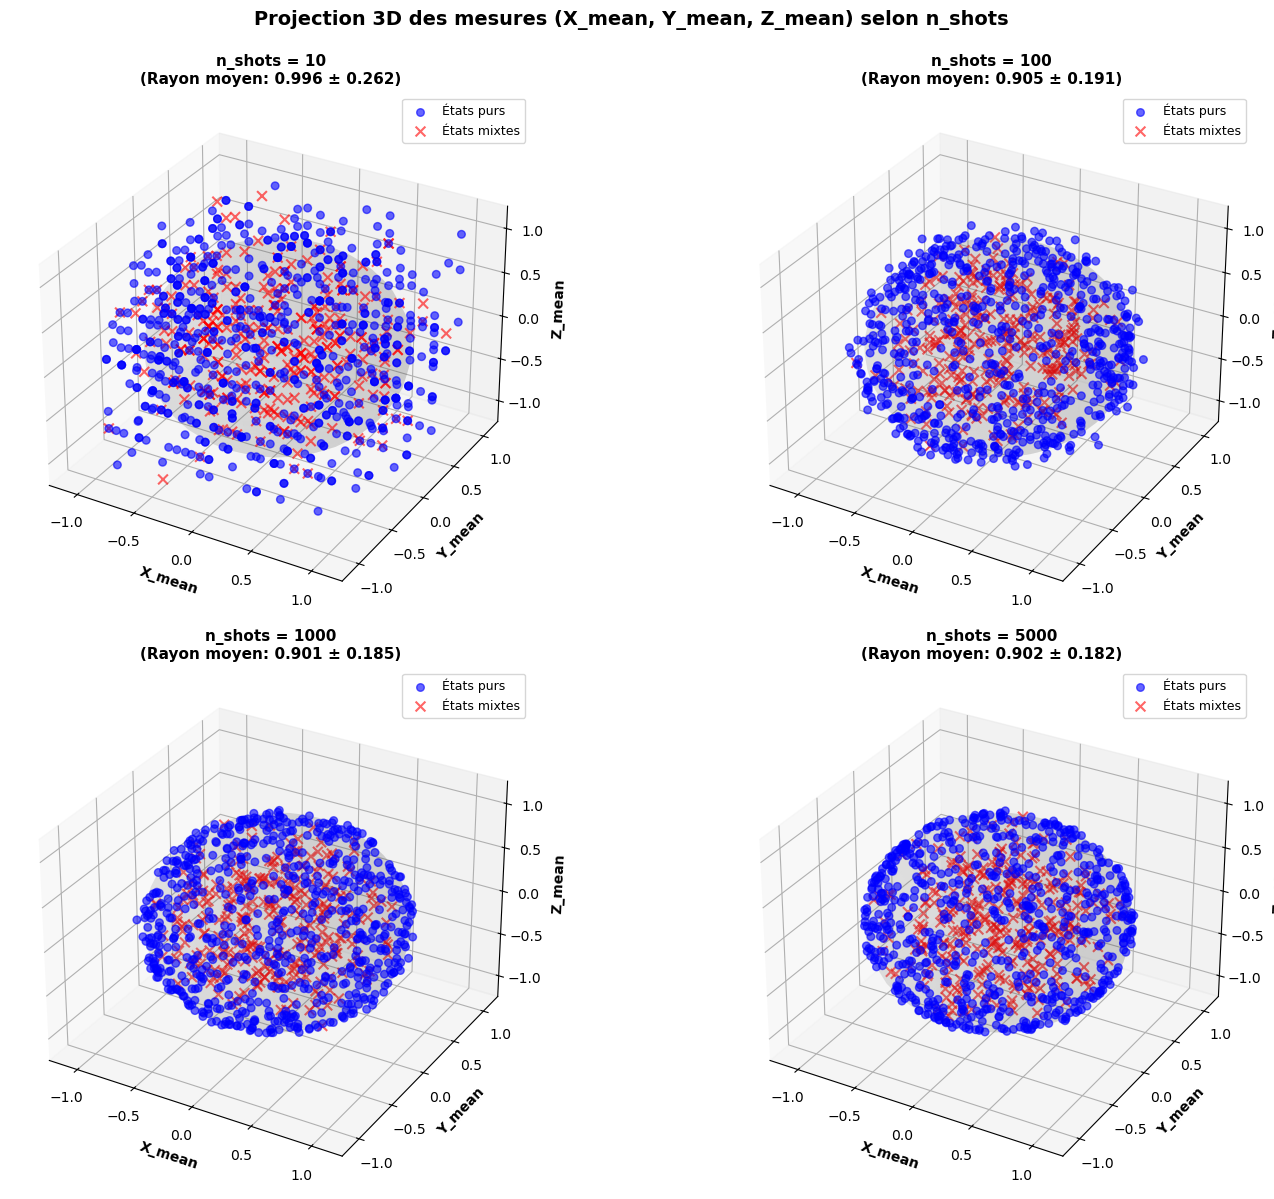


INTERPRÉTATION:
• Sphère grise: Sphère de Bloch idéale (rayon = 1)
• Points bleus (o): États purs (devraient être près de la sphère)
• Points rouges (x): États mixtes (devraient être à l'intérieur de la sphère)
• Plus n_shots augmente, plus les mesures se rapprochent de la vraie géométrie
• Avec n_shots faible: plus de bruit, points très dispersés
• Avec n_shots élevé: mesures plus précises, distribution plus concentrée



In [16]:
# Projection 3D des mesures (X_mean, Y_mean, Z_mean) selon n_shots
from mpl_toolkits.mplot3d import Axes3D

n_shots_test = [10, 100, 1000, 5000]
fig = plt.figure(figsize=(16, 12))

print("Génération des projections 3D pour différentes valeurs de n_shots...\n")

for idx, n_shots in enumerate(n_shots_test, 1):
    # Générer dataset
    df_temp, X_temp, y_temp = build_purity_classification_dataset(
        n_shots=n_shots,
        n_states_total=1000,
        mixed_proportion=0.3
    )
    
    # Sous-graphique 3D
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    
    # Séparer les états purs et mixtes
    pure_mask = y_temp == 1
    mixed_mask = y_temp == 0
    
    # Scatter plot des états purs et mixtes
    ax.scatter(df_temp.loc[pure_mask, 'X_mean'],
               df_temp.loc[pure_mask, 'Y_mean'],
               df_temp.loc[pure_mask, 'Z_mean'],
               c='blue', marker='o', s=30, alpha=0.6, label='États purs')
    
    ax.scatter(df_temp.loc[mixed_mask, 'X_mean'],
               df_temp.loc[mixed_mask, 'Y_mean'],
               df_temp.loc[mixed_mask, 'Z_mean'],
               c='red', marker='x', s=50, alpha=0.6, label='États mixtes')
    
    # Ajouter la sphère de Bloch (rayon = 1)
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 20)
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.1, color='gray')
    
    # Calcul des statistiques
    mean_radius = np.sqrt(df_temp['X_mean']**2 + df_temp['Y_mean']**2 + df_temp['Z_mean']**2).mean()
    std_radius = np.sqrt(df_temp['X_mean']**2 + df_temp['Y_mean']**2 + df_temp['Z_mean']**2).std()
    
    # Labels et titre
    ax.set_xlabel('X_mean', fontsize=10, fontweight='bold')
    ax.set_ylabel('Y_mean', fontsize=10, fontweight='bold')
    ax.set_zlabel('Z_mean', fontsize=10, fontweight='bold')
    ax.set_title(f'n_shots = {n_shots}\n(Rayon moyen: {mean_radius:.3f} ± {std_radius:.3f})', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    
    # Fixer les limites
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_zlim([-1.2, 1.2])
    
    print(f"n_shots={n_shots:5d} | Rayon moyen: {mean_radius:.4f} ± {std_radius:.4f}")

plt.suptitle('Projection 3D des mesures (X_mean, Y_mean, Z_mean) selon n_shots', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRÉTATION:")
print("="*80)
print("• Sphère grise: Sphère de Bloch idéale (rayon = 1)")
print("• Points bleus (o): États purs (devraient être près de la sphère)")
print("• Points rouges (x): États mixtes (devraient être à l'intérieur de la sphère)")
print("• Plus n_shots augmente, plus les mesures se rapprochent de la vraie géométrie")
print("• Avec n_shots faible: plus de bruit, points très dispersés")
print("• Avec n_shots élevé: mesures plus précises, distribution plus concentrée\n")

ANALYSE DE CONVERGENCE: Distance mesure-réalité vs n_shots

Concept: La Loi des Grands Nombres prédit que l'erreur d'estimation
décroît comme 1/√n_shots pour les moyennes statistiques.

n_shots=   10 | Distance: 0.422317 ± 0.186193
n_shots=   10 | Distance: 0.422317 ± 0.186193
n_shots=   25 | Distance: 0.268535 ± 0.118890
n_shots=   25 | Distance: 0.268535 ± 0.118890
n_shots=   50 | Distance: 0.190384 ± 0.084474
n_shots=   50 | Distance: 0.190384 ± 0.084474
n_shots=  100 | Distance: 0.135277 ± 0.062105
n_shots=  100 | Distance: 0.135277 ± 0.062105
n_shots=  250 | Distance: 0.084998 ± 0.038452
n_shots=  250 | Distance: 0.084998 ± 0.038452
n_shots=  500 | Distance: 0.059936 ± 0.026870
n_shots=  500 | Distance: 0.059936 ± 0.026870
n_shots= 1000 | Distance: 0.042246 ± 0.019386
n_shots= 1000 | Distance: 0.042246 ± 0.019386
n_shots= 2500 | Distance: 0.026800 ± 0.012032
n_shots= 2500 | Distance: 0.026800 ± 0.012032
n_shots= 5000 | Distance: 0.018910 ± 0.008567
n_shots= 5000 | Distance: 0.0189

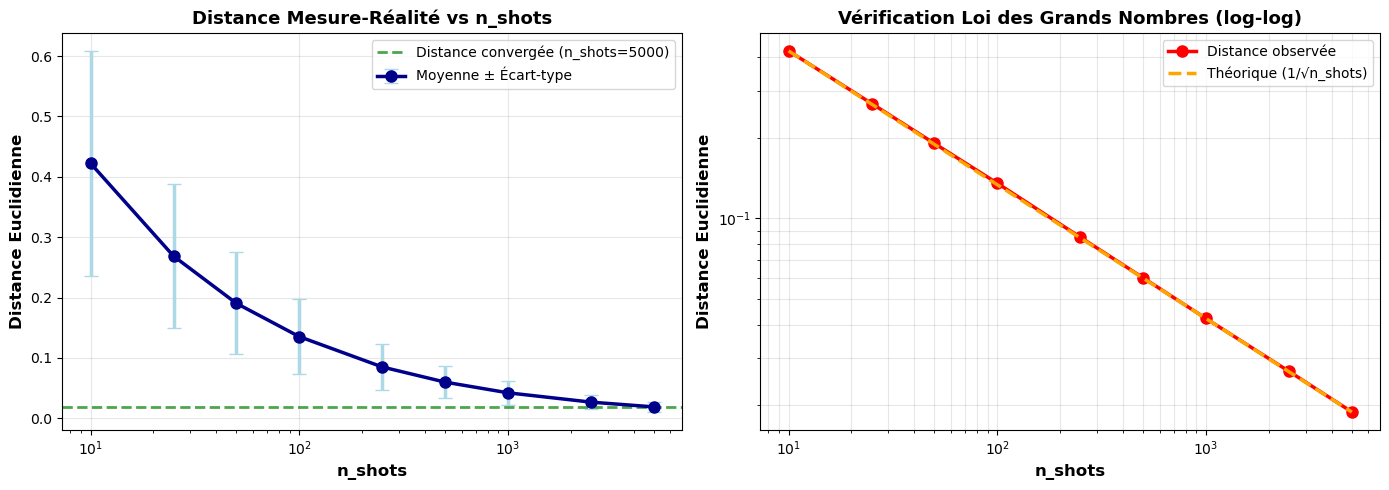


interprétation ?


In [17]:
# Convergence de la distance entre état mesuré et état réel selon n_shots
# Application de la Loi des Grands Nombres

n_shots_values = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000]
distance_stats = []

print("="*80)
print("ANALYSE DE CONVERGENCE: Distance mesure-réalité vs n_shots")
print("="*80)
print("\nConcept: La Loi des Grands Nombres prédit que l'erreur d'estimation")
print("décroît comme 1/√n_shots pour les moyennes statistiques.\n")

for n_shots in n_shots_values:
    # Générer dataset
    df_temp, X_temp, y_temp = build_purity_classification_dataset(
        n_shots=n_shots,
        n_states_total=2000,
        mixed_proportion=0.3
    )
    
    # Calculer la distance Euclidienne entre (X_mean, Y_mean, Z_mean) et (X_real, Y_real, Z_real)
    distances = np.sqrt(
        (df_temp['X_mean'] - df_temp['X_real'])**2 +
        (df_temp['Y_mean'] - df_temp['Y_real'])**2 +
        (df_temp['Z_mean'] - df_temp['Z_real'])**2
    )
    
    # Statistiques
    mean_distance = distances.mean()
    std_distance = distances.std()
    
    distance_stats.append({
        'n_shots': n_shots,
        'mean_distance': mean_distance,
        'std_distance': std_distance
    })
    
    print(f"n_shots={n_shots:5d} | Distance: {mean_distance:.6f} ± {std_distance:.6f}")

# Créer DataFrame
distance_df = pd.DataFrame(distance_stats)

# Visualisation: 2 graphiques
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Distance moyenne avec erreur
ax1 = axes[0]
ax1.errorbar(distance_df['n_shots'], distance_df['mean_distance'],
             yerr=distance_df['std_distance'],
             fmt='o-', capsize=5, linewidth=2.5, markersize=8,
             color='darkblue', ecolor='lightblue', label='Moyenne ± Écart-type')
ax1.axhline(y=distance_df['mean_distance'].iloc[-1], color='green', linestyle='--',
            linewidth=2, label=f'Distance convergée (n_shots=5000)', alpha=0.7)
ax1.set_xlabel('n_shots', fontsize=12, fontweight='bold')
ax1.set_ylabel('Distance Euclidienne', fontsize=12, fontweight='bold')
ax1.set_title('Distance Mesure-Réalité vs n_shots', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Graphique 2: Log-log pour vérifier la loi 1/√n_shots
ax2 = axes[1]
ax2.loglog(distance_df['n_shots'], distance_df['mean_distance'],
           'o-', linewidth=2.5, markersize=8, color='red', label='Distance observée')

# Courbe théorique 1/√n_shots
theoretical_distance = distance_df['mean_distance'].iloc[0] * np.sqrt(distance_df['n_shots'].iloc[0]) / np.sqrt(distance_df['n_shots'])
ax2.loglog(distance_df['n_shots'], theoretical_distance,
           '--', linewidth=2.5, color='orange', label='Théorique (1/√n_shots)')

ax2.set_xlabel('n_shots', fontsize=12, fontweight='bold')
ax2.set_ylabel('Distance Euclidienne', fontsize=12, fontweight='bold')
ax2.set_title('Vérification Loi des Grands Nombres (log-log)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Analyse détaillée et recommandation
print("\n" + "="*80)
print("interprétation ?")
print("="*80)

# Trouver le point d'inflexion (diminution < 10%)
distances = distance_df['mean_distance'].values
initial_distance = distances[0]

for i in range(1, len(distances)):
    reduction = (initial_distance - distances[i]) / initial_distance * 100
    if i > 1:
        prev_reduction = (initial_distance - distances[i-1]) / initial_distance * 100
        improvement = reduction - prev_reduction
        if improvement < 5:  # Amélioration inférieure à 5%
            optimal_idx = i - 1
            break
else:
    optimal_idx = len(distance_df) - 1

optimal_n_shots = distance_df.loc[optimal_idx, 'n_shots']
optimal_distance = distance_df.loc[optimal_idx, 'mean_distance']
optimal_reduction = (initial_distance - optimal_distance) / initial_distance * 100

optimal n_shots = 5000

In [18]:
# Dataset creation

df_purity_5000, X, y = build_purity_classification_dataset(
    n_shots=100,
    n_states_total=5000,
    mixed_proportion=0.5  # proportion of mixed states
)

print(f"Dataset shape: {df_purity_5000.shape}")
print(f"Labels distribution:\n{y.value_counts()}")
print(f"\nDataset columns:\n{df_purity_5000.columns.tolist()}")
print(f"\X columns (à revoir):\n{X.columns.tolist()}")

Dataset shape: (5000, 14)
Labels distribution:
label_purity
0    2500
1    2500
Name: count, dtype: int64

Dataset columns:
['X_mean', 'Y_mean', 'Z_mean', 'X_real', 'Y_real', 'Z_real', 'theta_ideal', 'phi_ideal', 'X_ideal', 'Y_ideal', 'Z_ideal', 'bloch_radius_real', 'is_pure', 'label_purity']
\X columns (à revoir):
['X_mean', 'Y_mean', 'Z_mean', 'bloch_radius_real']


In [19]:
df_purity_5000.describe()

,X_mean,Y_mean,Z_mean,X_real,Y_real,Z_real,theta_ideal,phi_ideal,X_ideal,Y_ideal,Z_ideal,bloch_radius_real,label_purity
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,0.002780,0.004580,-0.003280,0.001725,0.003932,-0.004529,1.575757,3.113954,-0.000181,0.003416,-0.001858,0.833913,0.50000
std,0.498931,0.503523,0.510008,0.491250,0.496683,0.502447,0.692852,1.806747,0.570133,0.577908,0.584086,0.212047,0.50005
min,-1.000000,-1.000000,-1.000000,-0.999629,-0.999967,-0.999520,0.059671,0.006675,-0.999629,-0.999967,-0.999520,0.213999,0.00000
25%,-0.380000,-0.380000,-0.400000,-0.363349,-0.375072,-0.386173,1.040227,1.534766,-0.482205,-0.503204,-0.519135,0.669094,0.00000
50%,0.000000,0.010000,0.000000,-0.000446,0.008914,0.007124,1.559005,3.112220,-0.000702,0.011357,0.011791,0.989956,0.50000
75%,0.380000,0.400000,0.380000,0.364620,0.386438,0.373264,2.116635,4.680082,0.483688,0.517619,0.506024,1.000000,1.00000
max,1.000000,1.000000,1.000000,0.999848,0.998851,0.998220,3.110621,6.277505,0.999848,0.998851,0.998220,1.000000,1.00000


array([[<Axes: title={'center': 'X_mean'}>,
        <Axes: title={'center': 'Y_mean'}>,
        <Axes: title={'center': 'Z_mean'}>,
        <Axes: title={'center': 'X_real'}>],
       [<Axes: title={'center': 'Y_real'}>,
        <Axes: title={'center': 'Z_real'}>,
        <Axes: title={'center': 'theta_ideal'}>,
        <Axes: title={'center': 'phi_ideal'}>],
       [<Axes: title={'center': 'X_ideal'}>,
        <Axes: title={'center': 'Y_ideal'}>,
        <Axes: title={'center': 'Z_ideal'}>,
        <Axes: title={'center': 'bloch_radius_real'}>],
       [<Axes: title={'center': 'label_purity'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

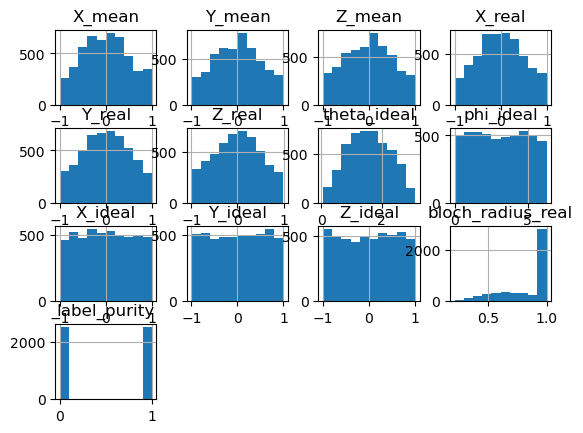

In [20]:
df_purity_5000.hist()

In [21]:
X_purity_5000=df_purity_5000[['X_mean','Y_mean','Z_mean']]
y_purity_5000=df_purity_5000['label_purity']

# standardization
X_purity_5000_scaled=scaler.fit_transform(X_purity_5000)

#splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X_purity_5000_scaled, y_purity_5000, test_size=0.2, random_state=42, stratify=y_purity_5000)

# selecting the best parameters from the grid search
model_5000 = SVC(**grid_search.best_params_)
model_5000.fit(X_train, y_train)
y_pred = model_5000.predict(X_test)  

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.88       500
           1       0.85      0.94      0.90       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [37]:
model_poly_2=SVC(C= 10, gamma= 'scale', kernel= 'poly', degree=2)
model_poly_2.fit(X_train, y_train)
y_pred_poly_2=model_poly_2.predict(X_test)
print(classification_report(y_test, y_pred_poly_2))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       500
           1       0.85      0.93      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.88      1000
weighted avg       0.89      0.89      0.88      1000



C:\Users\hvira\AppData\Local\Temp\ipykernel_25260\65606928.py:38: UserWarning: The following kwargs were not used by contour: 'label'
  ax1.contour(xx_2d, zz_2d, Z_rbf_2d, levels=[0.5], colors='black', linewidths=2, label='Decision Boundary')
C:\Users\hvira\AppData\Local\Temp\ipykernel_25260\65606928.py:66: UserWarning: The following kwargs were not used by contour: 'label'
  ax2.contour(xx_2d, zz_2d, Z_poly_2d, levels=[0.5], colors='black', linewidths=2, label='Decision Boundary')


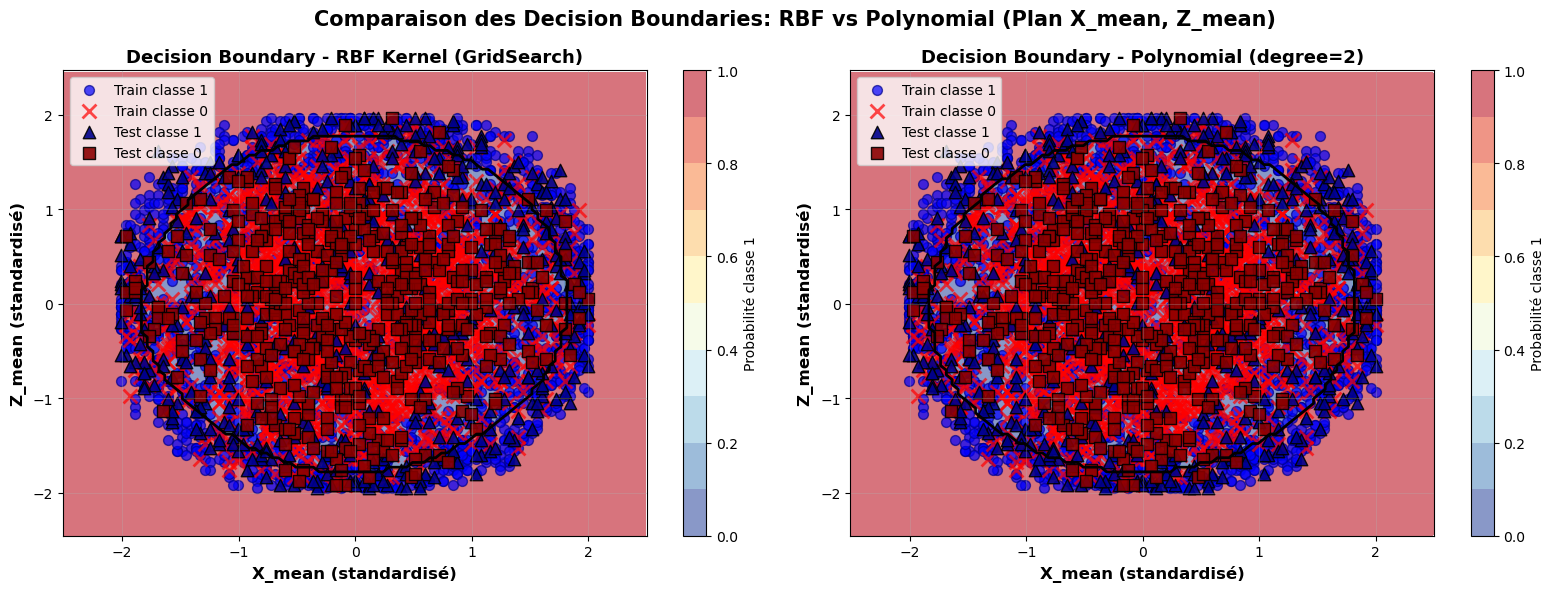

COMPARAISON DES KERNELS - DECISION BOUNDARIES EN 2D (X, Z)

✓ RBF Kernel (GridSearch):
  Paramètres: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Accuracité test (3D complet): 0.8956

✓ Polynomial Kernel (degree=2):
  Paramètres: C=10, gamma='scale', kernel='poly', degree=2
  Accuracité test (3D complet): 0.8902

✓ Différence d'accuracy: 0.0055
  → RBF est meilleur: True

✓ Visualisation 2D (Plan X_mean, Z_mean avec Y=0):
  • Fond coloré: Région de décision (bleu=classe 1, rouge=classe 0)
  • Ligne noire: Frontière de décision (boundary)
  • Cercles bleus (o): Points d'entraînement classe 1
  • Croix rouges (x): Points d'entraînement classe 0
  • Triangles bleus (^): Points de test classe 1
  • Carrés rouges (s): Points de test classe 0
  • Plan XZ avec Y=0 (coupe centrale de la sphère de Bloch)
  • Le RBF crée des régions courbes (non-linéaires)
  • Le Polynomial crée des régions facettées (quadratiques)


In [38]:
# Visualisation des decision boundaries en 2D: RBF vs Polynomial (plan X_mean, Z_mean)

y_train_labels = y_train.values
y_test_labels = y_test.values

# Créer une grille 2D fine sur le plan (X, Z) - axes 0 et 2
h = 0.05  # pas de la grille pour 2D (plus fin que 3D)
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
z_min, z_max = X_train[:, 2].min() - 0.5, X_train[:, 2].max() + 0.5

xx_2d, zz_2d = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(z_min, z_max, h))

# Pour les prédictions, il faut passer 3 features (X, Y, Z)
# On va utiliser la moyenne Y (0) pour les points de grille
y_mean_2d = np.zeros_like(xx_2d)

# Créer les points de grille avec Y = 0 (plan central)
# Format: [X, Y, Z]
grid_points = np.c_[xx_2d.ravel(), y_mean_2d.ravel(), zz_2d.ravel()]

# Prédictions sur la grille pour les deux modèles
Z_rbf_2d = model_5000.predict(grid_points)
Z_poly_2d = model_poly_2.predict(grid_points)

# Reshape pour contourf
Z_rbf_2d = Z_rbf_2d.reshape(xx_2d.shape)
Z_poly_2d = Z_poly_2d.reshape(xx_2d.shape)

# Créer la figure avec deux subplots 2D
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: RBF Kernel
ax1 = axes[0]

# Afficher la surface de décision RBF avec contourf
contour_rbf = ax1.contourf(xx_2d, zz_2d, Z_rbf_2d, levels=10, cmap='RdYlBu_r', alpha=0.6)
ax1.contour(xx_2d, zz_2d, Z_rbf_2d, levels=[0.5], colors='black', linewidths=2, label='Decision Boundary')

# Points d'entraînement (X et Z)
ax1.scatter(X_train[y_train_labels == 1, 0], X_train[y_train_labels == 1, 2],
           c='blue', marker='o', s=50, alpha=0.7, edgecolors='darkblue', linewidth=1, label='Train classe 1')
ax1.scatter(X_train[y_train_labels == 0, 0], X_train[y_train_labels == 0, 2],
           c='red', marker='x', s=100, alpha=0.7, linewidth=2, label='Train classe 0')

# Points de test (X et Z)
ax1.scatter(X_test[y_test_labels == 1, 0], X_test[y_test_labels == 1, 2],
           c='darkblue', marker='^', s=80, alpha=0.9, edgecolors='black', linewidth=1, label='Test classe 1')
ax1.scatter(X_test[y_test_labels == 0, 0], X_test[y_test_labels == 0, 2],
           c='darkred', marker='s', s=80, alpha=0.9, edgecolors='black', linewidth=1, label='Test classe 0')

ax1.set_xlim([x_min, x_max])
ax1.set_ylim([z_min, z_max])
ax1.set_xlabel('X_mean (standardisé)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Z_mean (standardisé)', fontsize=12, fontweight='bold')
ax1.set_title('Decision Boundary - RBF Kernel (GridSearch)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, alpha=0.3)
plt.colorbar(contour_rbf, ax=ax1, label='Probabilité classe 1')

# Subplot 2: Polynomial Kernel (degree=2)
ax2 = axes[1]

# Afficher la surface de décision Polynomial avec contourf
contour_poly = ax2.contourf(xx_2d, zz_2d, Z_poly_2d, levels=10, cmap='RdYlBu_r', alpha=0.6)
ax2.contour(xx_2d, zz_2d, Z_poly_2d, levels=[0.5], colors='black', linewidths=2, label='Decision Boundary')

# Points d'entraînement (X et Z)
ax2.scatter(X_train[y_train_labels == 1, 0], X_train[y_train_labels == 1, 2],
           c='blue', marker='o', s=50, alpha=0.7, edgecolors='darkblue', linewidth=1, label='Train classe 1')
ax2.scatter(X_train[y_train_labels == 0, 0], X_train[y_train_labels == 0, 2],
           c='red', marker='x', s=100, alpha=0.7, linewidth=2, label='Train classe 0')

# Points de test (X et Z)
ax2.scatter(X_test[y_test_labels == 1, 0], X_test[y_test_labels == 1, 2],
           c='darkblue', marker='^', s=80, alpha=0.9, edgecolors='black', linewidth=1, label='Test classe 1')
ax2.scatter(X_test[y_test_labels == 0, 0], X_test[y_test_labels == 0, 2],
           c='darkred', marker='s', s=80, alpha=0.9, edgecolors='black', linewidth=1, label='Test classe 0')

ax2.set_xlim([x_min, x_max])
ax2.set_ylim([z_min, z_max])
ax2.set_xlabel('X_mean (standardisé)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Z_mean (standardisé)', fontsize=12, fontweight='bold')
ax2.set_title('Decision Boundary - Polynomial (degree=2)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)
plt.colorbar(contour_poly, ax=ax2, label='Probabilité classe 1')

plt.suptitle('Comparaison des Decision Boundaries: RBF vs Polynomial (Plan X_mean, Z_mean)', 
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Afficher les statistiques de comparaison
print("="*80)
print("COMPARAISON DES KERNELS - DECISION BOUNDARIES EN 2D (X, Z)")
print("="*80)

# Prédictions pour évaluation sur le plan 2D avec Y=0
from sklearn.metrics import f1_score, classification_report

y_pred_rbf_2d = model_5000.predict(X_test)
y_pred_poly_2d = model_poly_2.predict(X_test)

rbf_f1_score_2d = f1_score(y_test_labels, y_pred_rbf_2d)
poly_f1_score_2d = f1_score(y_test_labels, y_pred_poly_2d)

print(f"\n✓ RBF Kernel (GridSearch):")
print(f"  Paramètres: {grid_search.best_params_}")
print(f"  Accuracité test (3D complet): {rbf_f1_score_2d:.4f}")

print(f"\n✓ Polynomial Kernel (degree=2):")
print(f"  Paramètres: C=10, gamma='scale', kernel='poly', degree=2")
print(f"  Accuracité test (3D complet): {poly_f1_score_2d:.4f}")

print(f"\n✓ Différence d'accuracy: {abs(rbf_f1_score_2d - poly_f1_score_2d):.4f}")
print(f"  → RBF est meilleur: {rbf_f1_score_2d > poly_f1_score_2d}")

print("\n✓ Visualisation 2D (Plan X_mean, Z_mean avec Y=0):")
print(f"  • Fond coloré: Région de décision (bleu=classe 1, rouge=classe 0)")
print(f"  • Ligne noire: Frontière de décision (boundary)")
print(f"  • Cercles bleus (o): Points d'entraînement classe 1")
print(f"  • Croix rouges (x): Points d'entraînement classe 0")
print(f"  • Triangles bleus (^): Points de test classe 1")
print(f"  • Carrés rouges (s): Points de test classe 0")
print(f"  • Plan XZ avec Y=0 (coupe centrale de la sphère de Bloch)")
print(f"  • Le RBF crée des régions courbes (non-linéaires)")
print(f"  • Le Polynomial crée des régions facettées (quadratiques)")
print("="*80)
